# Imadjust and local contrast alternative

Libraries imported

In [2]:
import numpy as np
import cv2 as cv
import pydicom as dicom
from matplotlib import pyplot as plt
import bisect
from numba import jit

In [3]:
!ls


Gaussian blur_1.png               adjustedimage1.dcm
IM15UD.dcm                        adjustedimage1.png
IM15UD.jpg                        dcm.png
IM19OP.png                        fig1.png
IM19UD.dcm                        imadjust_try.ipynb
IM21UD.dcm                        img15_blur.dcm
IM25OP.png                        img1_1.DCM
IM25UD.dcm                        img2_1.DCM
IM31UD.dcm                        op1.png
IM39UD.dcm                        out.dcm
IM_ADJUST_ALTERNATIVE_MANSI.ipynb task1_read.m
ImAdjust_alt.py                   task1_w1.py
Untitled.ipynb                    untitled0.py
adjustedimage.png                 untitled1.py


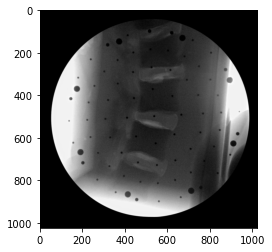

In [23]:
img15=dicom.dcmread('IM15UD.dcm').pixel_array
plt.imshow(img15,cmap='gray')
plt.show()

In [24]:
img15.dtype

dtype('uint16')

**Unit16 to unit8 conversion**

In [25]:
#uint16 to unit8 conversion
im1 = cv.convertScaleAbs(img15, alpha=(255.0/65535.0))


In [26]:
im1.dtype


dtype('uint8')

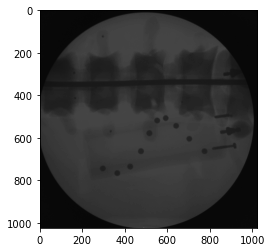

In [16]:
plt.imshow(im1,'gray')

**Method 1**

In [27]:
import bisect

def imadjust(src, tol=1, vin=[0,255], vout=(0,255)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    assert len(src.shape) == 2 ,'Input image should be 2-dims'

    tol = max(0, min(100, tol))   
    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.histogram(src,bins=list(range(256)),range=(0,255))[0]

        # Cumulative histogram
        cum = hist.copy()
        for i in range(0, 255): cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_right(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    vs = src-vin[0]
    vs[src<vin[0]]=0
    vd = vs*scale+0.5 + vout[0]
    vd[vd>vout[1]] = vout[1]
    dst = vd

    return dst

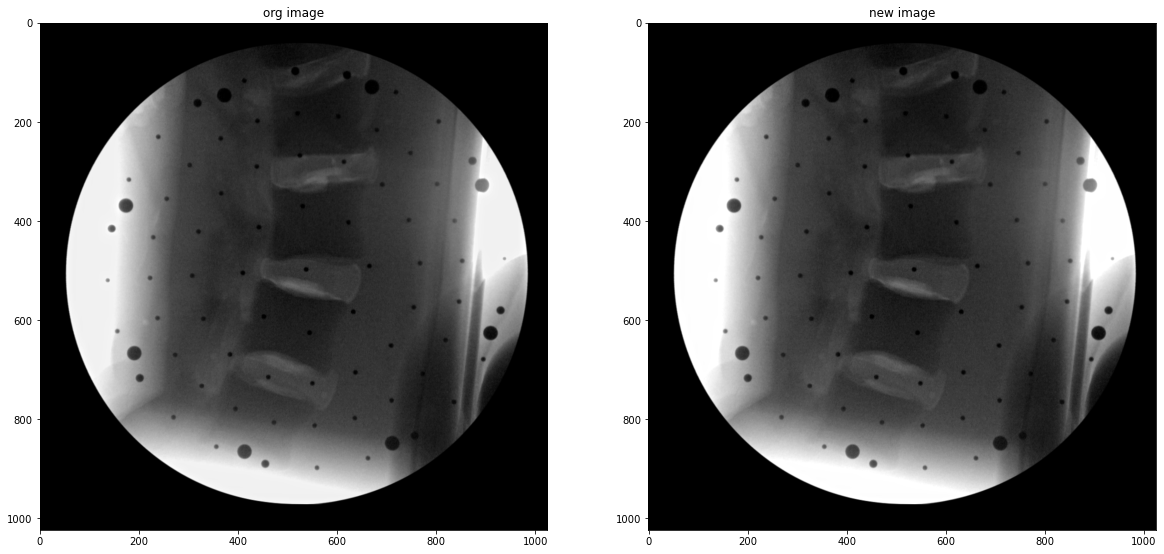

In [28]:
out=imadjust(im1)

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('org image')
ax1.imshow(im1,cmap = 'gray')
ax2.set_title('new image')
ax2.imshow(out,cmap = 'gray')
plt.show()

In [19]:
adjusted = cv2.imread('adjustedimage1.png',0)
plt.imshow(adjusted,'gray')
np.shape(adjusted)

NameError: name 'cv2' is not defined

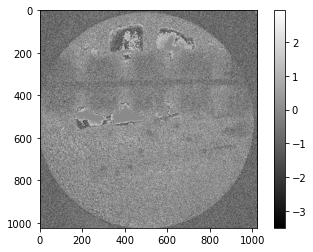

In [506]:
plt.imshow(out-adjusted,'gray')
plt.colorbar()

In [496]:
cv2.imshow('new_image',out)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [497]:
print(np.min(im1-I1))
print(np.max(im1-I1))

-192.0
6.5


**Method 2 - Equalise hist**

In [30]:
I2= cv.equalizeHist(im1)

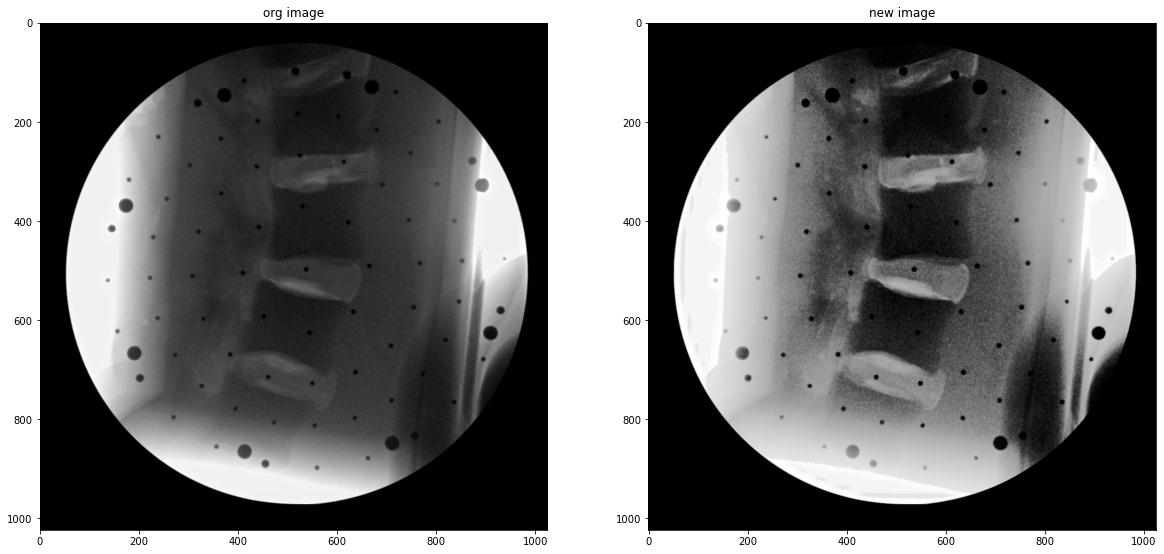

In [31]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('org image')
ax1.imshow(im1,cmap = 'gray')
ax2.set_title('new image')
ax2.imshow(I2,cmap = 'gray')
plt.show()

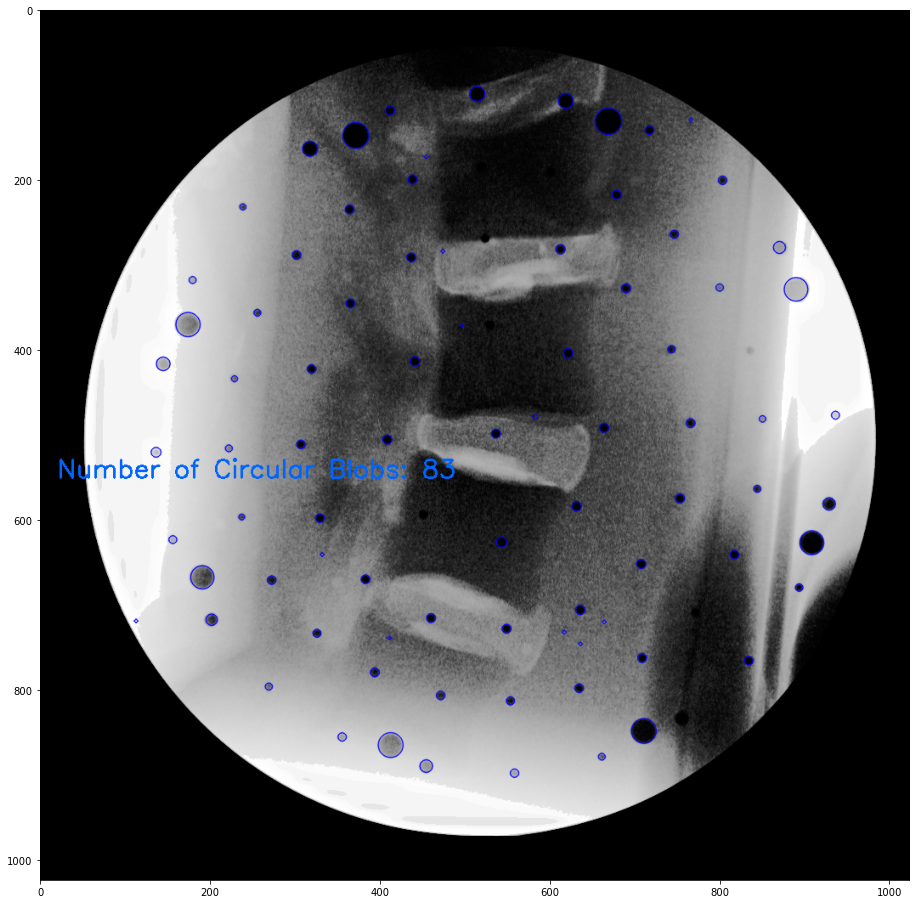

In [35]:
#GEEKSFORGEEKS METHOD:
params = cv.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 1
params.maxThreshold = 255

# Set Area filtering parameters
params.filterByArea = True
params.minArea = 12
 
# Set Circularity filtering parameters
params.filterByCircularity = True
params.minCircularity = 0.8
 
# Set Convexity filtering parameters
params.filterByConvexity = True
params.minConvexity = 0.7
     
# Set inertia filtering parameters
params.filterByInertia = True
params.minInertiaRatio = 0.01
 
# Create a detector with the parameters
detector = cv.SimpleBlobDetector_create(params)
     
# Detect blobs
keypoints = detector.detect(I2)
 
# Draw blobs on our image as red circles
blank = np.zeros((1, 1))
blobs = cv.drawKeypoints(I2, keypoints, blank, (0, 0, 255),
                          cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
number_of_blobs = len(keypoints)
text = "Number of Circular Blobs: " + str(len(keypoints))
cv.putText(blobs, text, (20, 550), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2)

plt.figure(figsize = (16,16))
plt.imshow(blobs)


**Method 3**

In [431]:
def imadjust1(x,a,b,c,d,gamma=0.9):
    # Similar to imadjust in MATLAB.
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
    #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    y = (((x ) / (b - a)) ** gamma) * (d - c) + c
    return y

In [452]:
I3=imadjust1(img15,img15.min(),img15.max(),0,0.99)

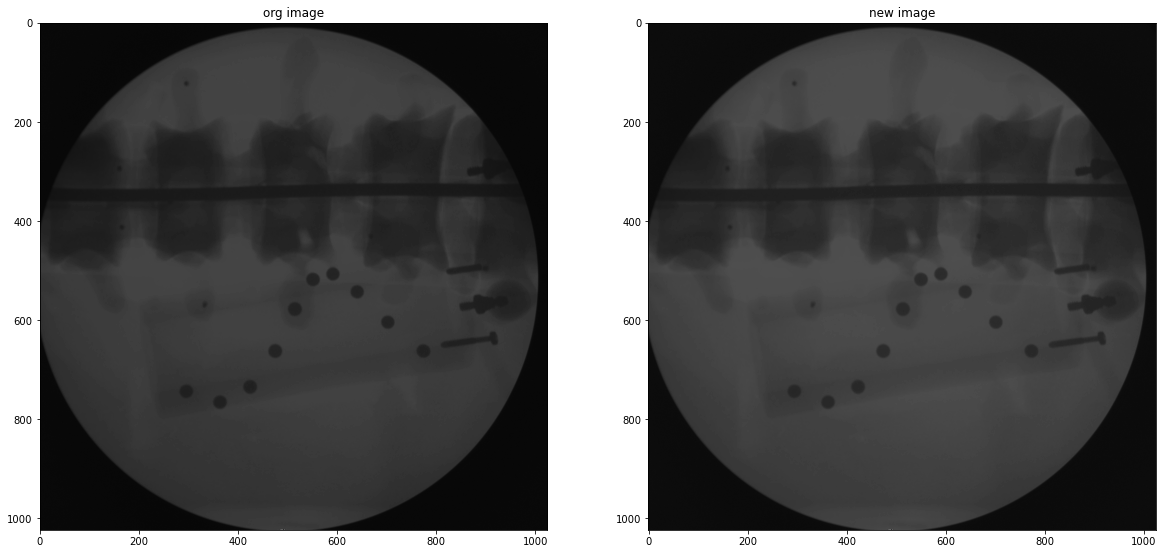

In [453]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('org image')
ax1.imshow(img15,cmap = 'gray')
ax2.set_title('new image')
ax2.imshow(I3,cmap = 'gray')
plt.show()

**For Local Contrast**

In [460]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
cl1 = clahe.apply(img15)
#output = cv2.adapthisteq(I3)

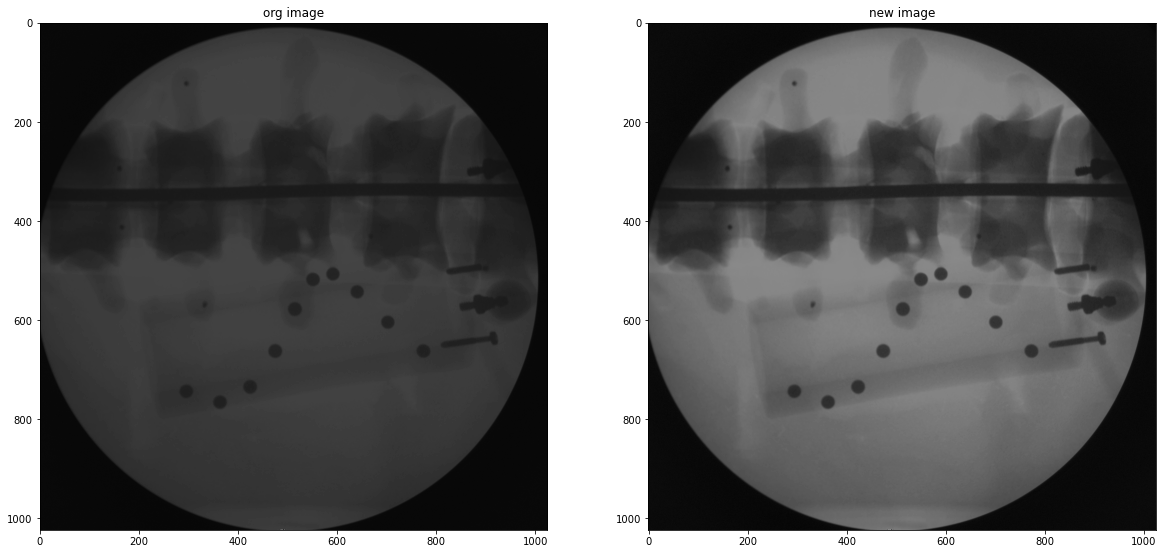

In [461]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('org image')
ax1.imshow(img15,cmap = 'gray')
ax2.set_title('new image')
ax2.imshow(cl1,cmap = 'gray')
plt.show()

In [436]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_GRAY2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_GRAY2BGR)
    return img



In [437]:
frame = increase_brightness(I3, value=20)


AttributeError: module 'cv2' has no attribute 'COLOR_GRAY2HSV'

**OpenCV method to change contrast and brightness of image**

In [438]:
alpha = 1
beta=20
new_image = np.zeros((img15.shape[0],img15.shape[1]))

In [439]:
for x in range(im1.shape[0]):
    for y in range(im1.shape[1]):
            new_image[x,y] = np.clip(alpha*im1[x,y] + beta, 0, 255)


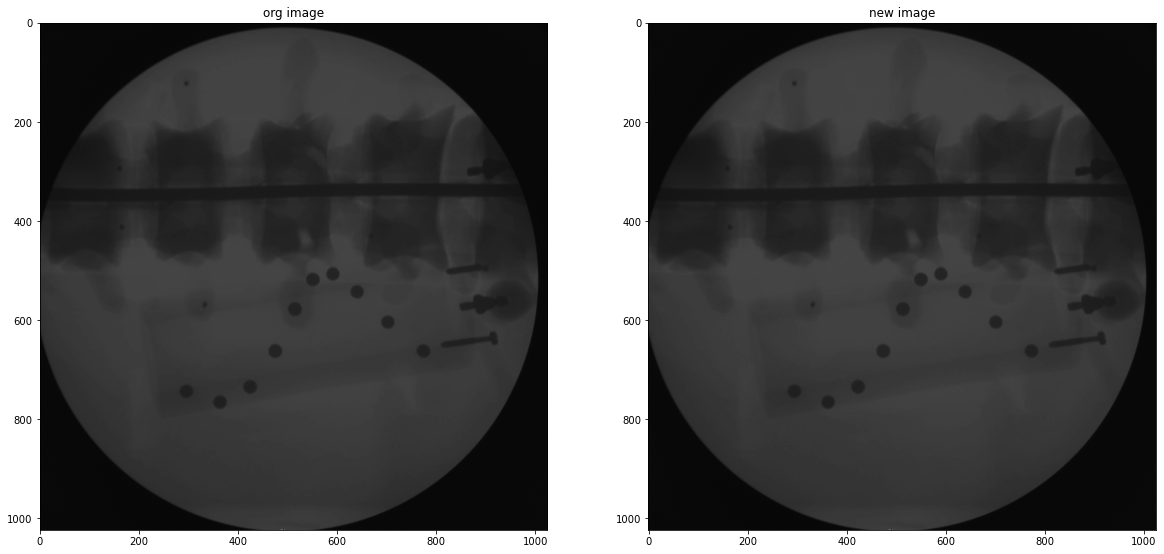

In [440]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('org image')
ax1.imshow(img15,cmap = 'gray')
ax2.set_title('new image')
ax2.imshow(new_image,cmap = 'gray')
plt.show()

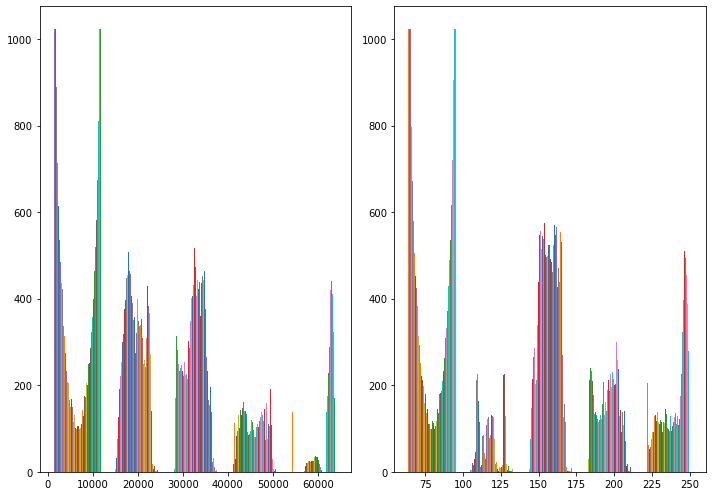

In [225]:
n_bins = 5
fig, (ax1,ax2) = plt.subplots(1, 2,figsize =(10, 7),tight_layout = True)
ax1.hist(img15, bins = n_bins)
ax2.hist(new_image, bins = n_bins)
plt.show()

In [476]:
p1, p99 = np.percentile(img15, (1, 99))
boy_arr3=Imadjust(img15,p1,p99,0.01,0.99,1)
plt.imshow(boy_arr3,cmap='gray')
plt.show()

cv2.imshow('3',boy_arr3)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(boy.min())
print(boy.max())
print(p1)
print(p99)

NameError: name 'Imadjust' is not defined